In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import random
import tensorflow as tf
import ntpath
from sklearn.utils import shuffle

In [2]:
tf.test.gpu_device_name() # We want to train our model with GPU so firstly, we should make sure our GPU is here.

'/device:GPU:0'

# Prepare Our DataFrame

In [3]:
TRAIN_TEST_SPLIT = 0.8 # Here we choose the train-test-split ratio, which is usually used.
IM_WIDTH = 200
IM_HEIGHT = 66

In [4]:
data_dir = '../data' # Directory of our dataset.
columns = ["center","left","right","steering","throttle","reverse","speed"] # We do here naming our features about driving.
df = pd.read_csv(os.path.join(data_dir,"driving_log.csv"), names=columns) # We import our dataset as DataFrame.
df.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,0.00,0.077689,0.0,0.003796
1,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,0.00,0.314660,0.0,0.221365
2,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,0.00,0.496547,0.0,0.530858
3,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,0.00,0.739879,0.0,1.093819
4,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,C:\Users\AlptheLightning\Desktop\beta_simulato...,-0.15,0.912017,0.0,1.731414


In [5]:
def path_leaf(path):
    head,tail=ntpath.split(path) # It is split path and image name.
    return str(tail) # We need here only image names.
df["center"] = df["center"].apply(path_leaf)
df["left"] = df["left"].apply(path_leaf)
df["right"] = df["right"].apply(path_leaf)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_10_22_18_32_38_758.jpg,left_2020_10_22_18_32_38_758.jpg,right_2020_10_22_18_32_38_758.jpg,0.00,0.077689,0.0,0.003796
1,center_2020_10_22_18_32_38_829.jpg,left_2020_10_22_18_32_38_829.jpg,right_2020_10_22_18_32_38_829.jpg,0.00,0.314660,0.0,0.221365
2,center_2020_10_22_18_32_38_900.jpg,left_2020_10_22_18_32_38_900.jpg,right_2020_10_22_18_32_38_900.jpg,0.00,0.496547,0.0,0.530858
3,center_2020_10_22_18_32_38_971.jpg,left_2020_10_22_18_32_38_971.jpg,right_2020_10_22_18_32_38_971.jpg,0.00,0.739879,0.0,1.093819
4,center_2020_10_22_18_32_39_038.jpg,left_2020_10_22_18_32_39_038.jpg,right_2020_10_22_18_32_39_038.jpg,-0.15,0.912017,0.0,1.731414


In [6]:
df = df.drop(['left', 'right', 'reverse'], 1)

In [7]:
df.head()

,center,steering,throttle,speed
0,center_2020_10_22_18_32_38_758.jpg,0.00,0.077689,0.003796
1,center_2020_10_22_18_32_38_829.jpg,0.00,0.314660,0.221365
2,center_2020_10_22_18_32_38_900.jpg,0.00,0.496547,0.530858
3,center_2020_10_22_18_32_38_971.jpg,0.00,0.739879,1.093819
4,center_2020_10_22_18_32_39_038.jpg,-0.15,0.912017,1.731414


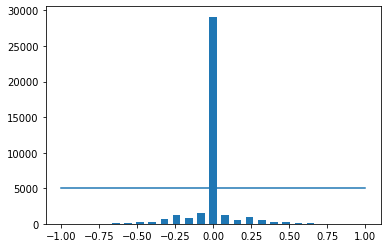

In [8]:
num_bins = 25
samples_per_bin = 5000
hist, bins = np.histogram(df["steering"], num_bins)
center = (bins[:-1] + bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df["steering"]), np.max(df["steering"])), (samples_per_bin, samples_per_bin))

**The distribution our dataset is bad so we need to a little tune this distribution.**

total data: 38010
removed 24117
remaining 13893


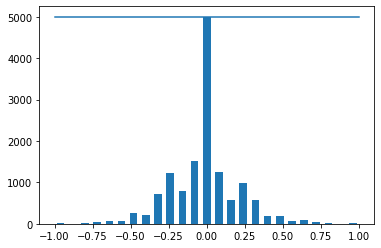

In [9]:
print("total data:",len(df))
remove_list = []
for j in range(num_bins):
    list_ = []  
    for i in range(len(df["steering"])):
        if bins[j] <= df["steering"][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print("removed", len(remove_list))
df.drop(df.index[remove_list],inplace=True)
print("remaining",len(df))

hist,_ = np.histogram(df["steering"], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df["steering"]), np.max(df["steering"])), (samples_per_bin, samples_per_bin))

**Now distribution of our dataset is better.**

In [10]:
df.tail()

,center,steering,throttle,speed
38005,center_2020_10_23_22_42_13_117.jpg,-0.25,1.000000,30.15746
38006,center_2020_10_23_22_42_13_189.jpg,-0.40,0.936671,30.14352
38007,center_2020_10_23_22_42_13_258.jpg,-0.60,0.695655,30.05942
38008,center_2020_10_23_22_42_13_327.jpg,-0.75,0.811517,30.05098
38009,center_2020_10_23_22_42_13_398.jpg,-0.95,1.000000,30.09530


In [11]:
df["speed"].max(), df["speed"].min(), df["speed"].mean()

(30.59637, 0.4264541, 30.133602503570142)

# Data PreProcess

**First of all, we need to divide our data set into two as train and test sets.**

In [12]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

train_up_to = int(train_up_to * 0.9)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

len(train_idx), len(valid_idx), len(test_idx)

(10002, 1112, 2779)

**Secondly, we do data augmentation.**

In [13]:
def drop(image):
    drop = iaa.Dropout(p=(0.0,0.1))
    image = drop.augment_image(image)
    return image

def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1,0.1), "y":(-0.1,0.1)})
    image = pan.augment_image(image)
    return image

def image_random_brightness(image):
    brightness = iaa.Multiply((0.2,1.2))
    image = brightness.augment_image(image)
    return image

def image_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.3:
        image = drop(image)
    if np.random.rand() < 0.3:
        image = pan(image)
    if np.random.rand() < 0.3:
        image = image_random_brightness(image)
    if np.random.rand() < 0.3:
        image, steering_angle = image_random_flip(image, steering_angle)
    return image, steering_angle

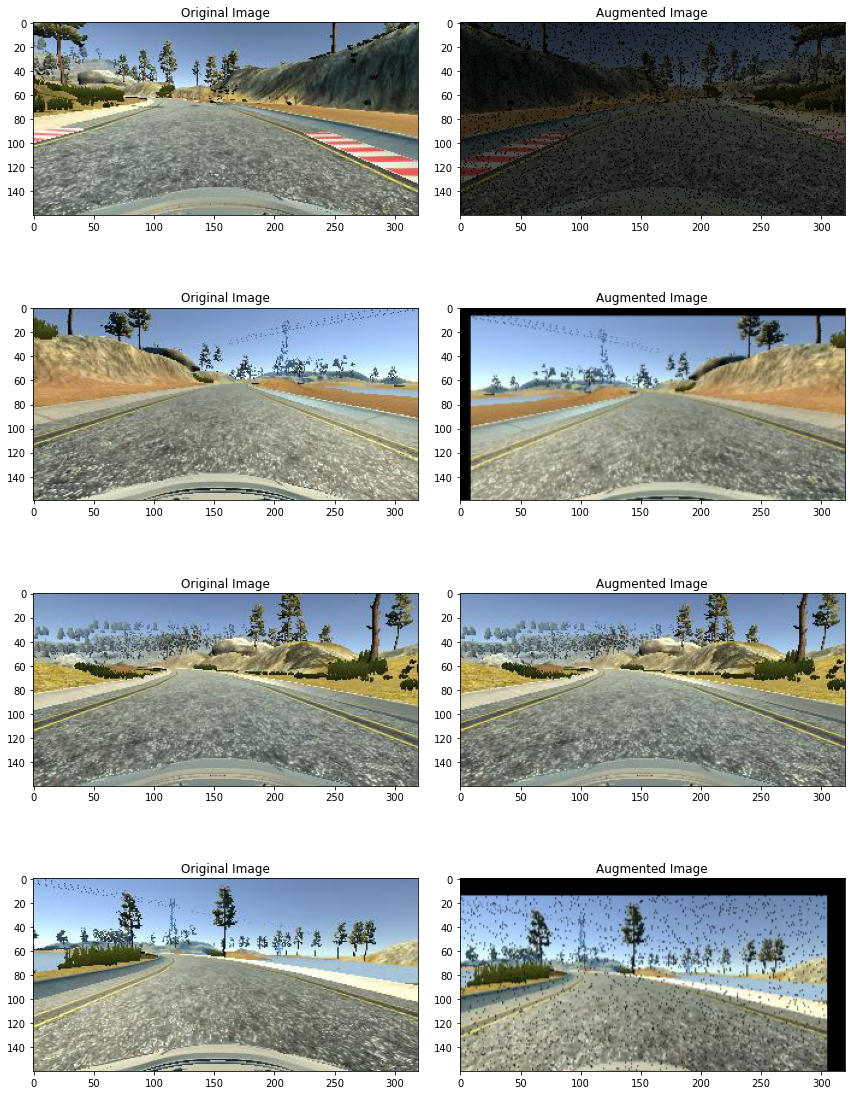

In [14]:
n_col = 2
n_row = 4
fig, axs = plt.subplots(n_row, n_col, figsize=(12, 16))
fig.tight_layout()

for i in range(4):
    rand_num = random.randint(0,len(df) - 1)
    random_image = "../data/IMG/" + df["center"].values[rand_num]
    random_steering = df["steering"].values[rand_num]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image,random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [15]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3),0)
    img = cv2.resize(img,(200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

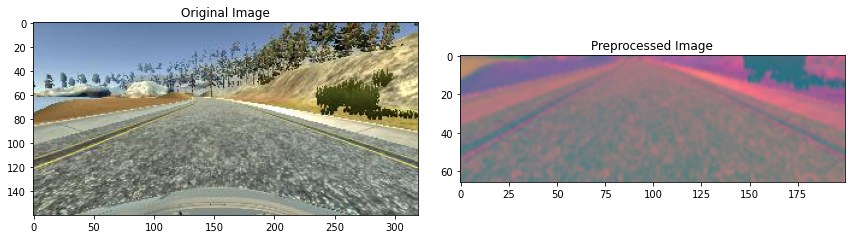

In [16]:
image = "../data/IMG/"+ df["center"].values[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1,2, figsize=(12,16))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed Image")

**We need to custom data generator because we took our images and features with DataFrame..**

In [17]:
def get_data_generator(df, indices, for_training, batch_size=128, isTraining=True):
    images, throttles, steers, speeds = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, steer, throttle, speed = ("../data/IMG/"+r['center']), r['steering'], r['throttle'], r["speed"]

            if isTraining:
                im, steer = random_augment(file, steer)
            else:
                im = mpimg.imread(file) # We read image with mpimg (this is return array, RGB)

            im = img_preprocess(im) # We are preprocessing all of our images.
            images.append(im)
            steer = (steer - df["steering"].min()) / (df["steering"].max() - df["steering"].min()) # We normalize our numerical features.
            steers.append(steer)
            throttles.append(throttle) # throttle is already between 0 and 1.
            speed = (speed - df["speed"].min()) / (df["speed"].max() - df["speed"].min()) # We normalize our numerical features.
            speeds.append(speed)
            if len(images) >= batch_size:
                yield np.array(images), [np.array(steers), np.array(throttles), np.array(speeds)]
                images, throttles, steers, speeds = [], [], [], []
        if not for_training:
            break

# Model Training

In [18]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.5)

optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [19]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True, kernel_size=(3,3), strides=(1,1)):
    _ = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding="same", strides=strides)(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)

    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False, kernel_size=(5,5))
_ = conv_block(_, filters=32)
_ = conv_block(_, filters=64, pool=False)
_ = conv_block(_, filters=64)
_ = conv_block(_, filters=128, pool=False)
_ = conv_block(_, filters=128)
_ = conv_block(_, filters=256, pool=False)
_ = conv_block(_, filters=256)
_ = conv_block(_, filters=512, pool=False)
_ = conv_block(_, filters=512)

flatten = Flatten()(_)

fc1 = Dense(units=256, activation='relu')(flatten)
do1 = Dropout(0.2)(fc1)
fc2 = Dense(units=256, activation='relu')(do1)
do2 = Dropout(0.2)(fc2)
fc3 = Dense(units=128, activation='relu')(do2)
do3 = Dropout(0.2)(fc3)
fc4 = Dense(units=128, activation='relu')(do3)
bottleneck = Dropout(0.2)(fc4)
steer_output = Dense(units=1,activation="sigmoid", name='steer_output')(bottleneck)
accel_output = Dense(units=1,activation="sigmoid", name='accel_output')(bottleneck)
speed_output = Dense(units=1,activation="sigmoid", name='speed_output')(bottleneck)

model = Model(inputs=input_layer, outputs=[steer_output, accel_output, speed_output])
model.compile(optimizer=optim, 
              loss={'steer_output': 'mae', 'accel_output': 'mae', 'speed_output': 'mae'},
              metrics={'steer_output': 'mae', 'accel_output': 'mae', 'speed_output': 'mae'})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 66, 200, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 66, 200, 32)  2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 66, 200, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 66, 200, 32)  128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [20]:
batch_size = 128
valid_batch_size = 128
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=20, 
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)
                    

Epoch 1/20
78/78 [==============================] - 37s 385ms/step - loss: 0.3003 - steer_output_loss: 0.2413 - accel_output_loss: 0.0210 - speed_output_loss: 0.0380 - steer_output_mae: 0.2413 - accel_output_mae: 0.0210 - speed_output_mae: 0.0380 - val_loss: 0.8331 - val_steer_output_loss: 0.0822 - val_accel_output_loss: 0.3576 - val_speed_output_loss: 0.3933 - val_steer_output_mae: 0.0822 - val_accel_output_mae: 0.3576 - val_speed_output_mae: 0.3933
Epoch 2/20
78/78 [==============================] - 30s 384ms/step - loss: 0.1939 - steer_output_loss: 0.1613 - accel_output_loss: 0.0133 - speed_output_loss: 0.0193 - steer_output_mae: 0.1613 - accel_output_mae: 0.0133 - speed_output_mae: 0.0193 - val_loss: 0.4693 - val_steer_output_loss: 0.0795 - val_accel_output_loss: 0.1778 - val_speed_output_loss: 0.2120 - val_steer_output_mae: 0.0795 - val_accel_output_mae: 0.1778 - val_speed_output_mae: 0.2120
Epoch 3/20
78/78 [==============================] - 29s 377ms/step - loss: 0.1606 - steer_

In [27]:
model.save("model-adam.h5")

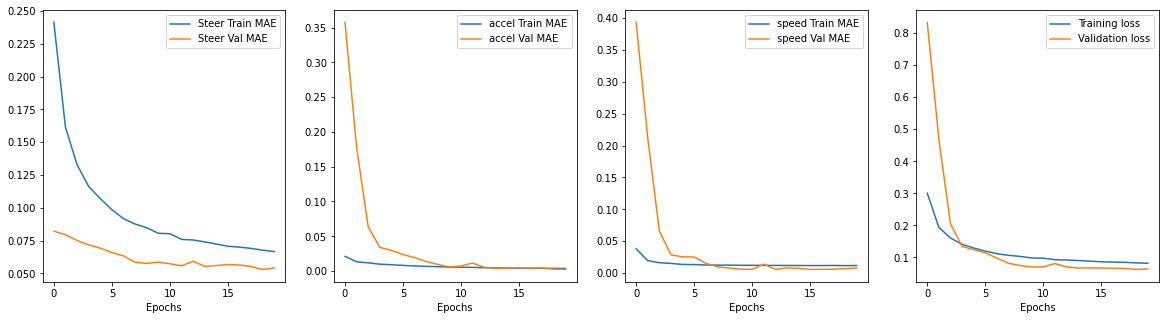

In [22]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['steer_output_loss'], label='Steer Train MAE')
    axes[0].plot(history.history['val_steer_output_loss'], label='Steer Val MAE')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['accel_output_loss'], label='accel Train MAE')
    axes[1].plot(history.history['val_accel_output_loss'], label='accel Val MAE')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()
    
    axes[2].plot(history.history['speed_output_loss'], label='speed Train MAE')
    axes[2].plot(history.history['val_speed_output_loss'], label='speed Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [23]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128, isTraining=False)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

/home/alp/.local/lib/python3.6/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


{'loss': 0.061425719410181046,
 'steer_output_loss': 0.05293770134449005,
 'accel_output_loss': 0.0015463816234841943,
 'speed_output_loss': 0.006941637955605984,
 'steer_output_mae': 0.05293770134449005,
 'accel_output_mae': 0.0015463816234841943,
 'speed_output_mae': 0.006941637955605984}

In [24]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128, isTraining=False)
x_test, (steer_true, accel_true, speed_true)= next(test_gen)
steer_pred, accel_pred, speed_pred = model.predict_on_batch(x_test)

In [25]:
steer_pred = steer_pred * (df["steering"].max() - df["steering"].min()) + df["steering"].min()
steer_true = steer_true * (df["steering"].max() - df["steering"].min()) + df["steering"].min()

speed_pred = speed_pred * (df["speed"].max() - df["speed"].min()) + df["speed"].min()
speed_true = speed_true * (df["speed"].max() - df["speed"].min()) + df["speed"].min()

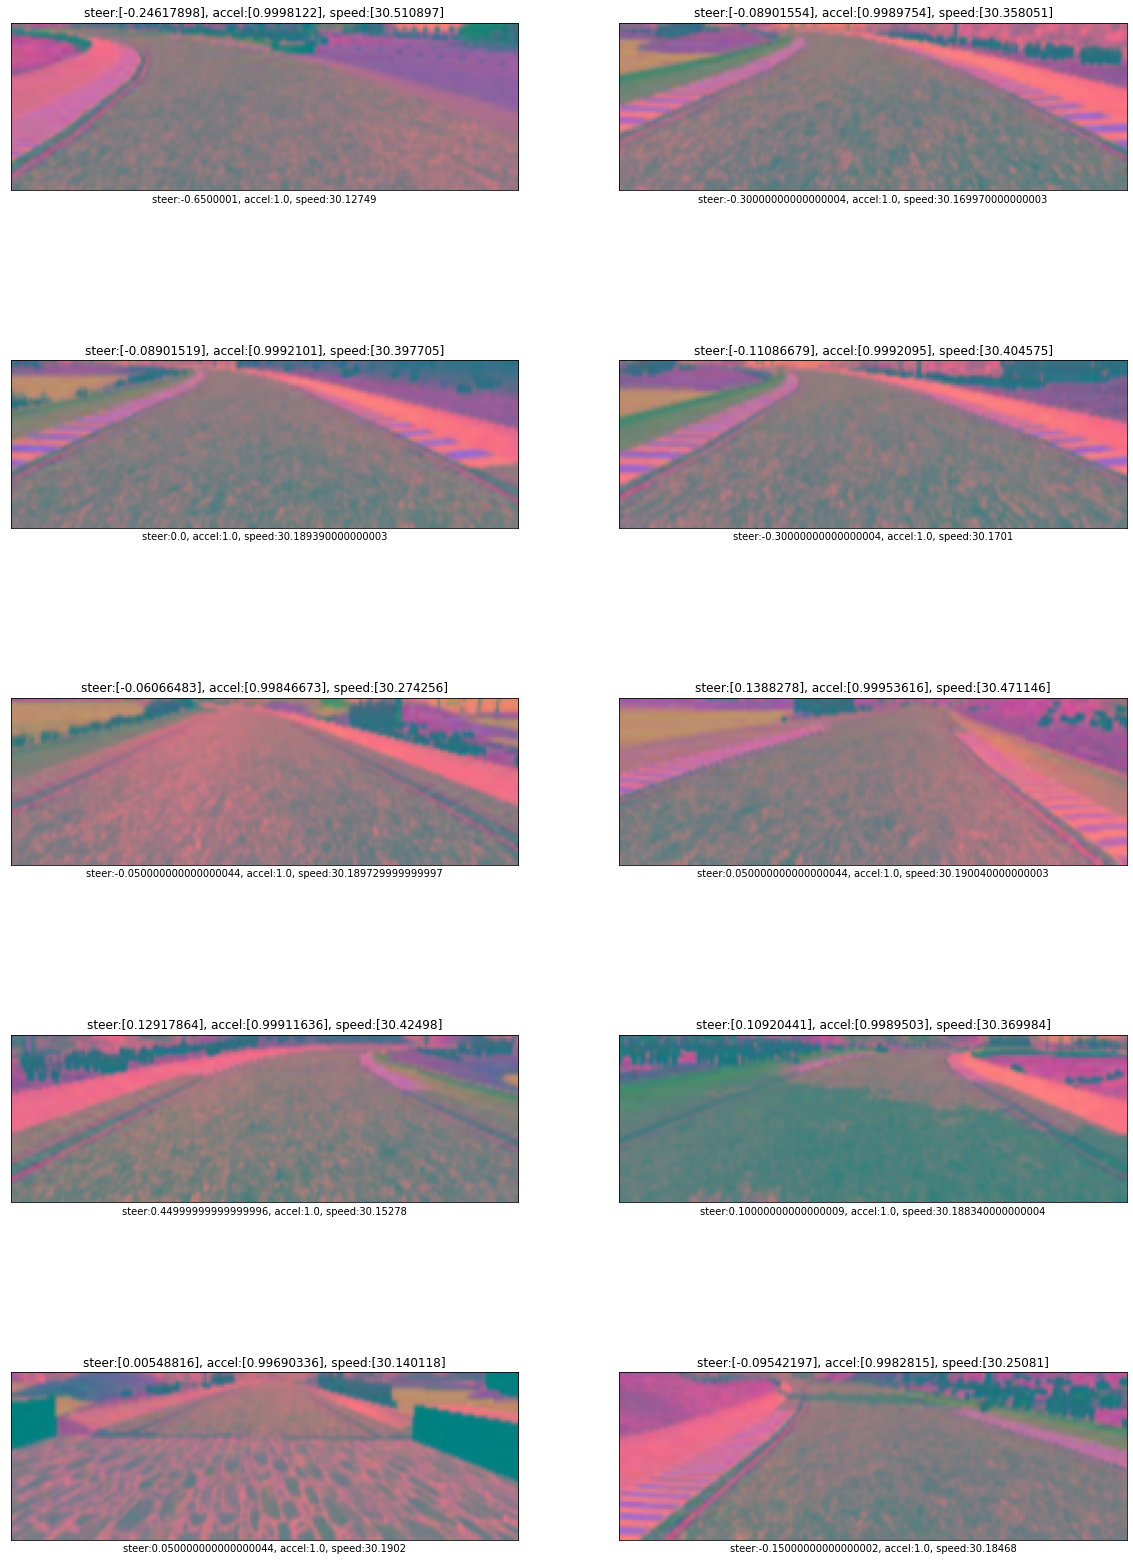

In [26]:
import math
n = 10
random_indices = np.random.permutation(n)
n_cols = 2
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title("steer:{}, accel:{}, speed:{}".format(steer_pred[img_idx], accel_pred[img_idx], speed_pred[img_idx]))
    ax.set_xlabel("steer:{}, accel:{}, speed:{}".format(steer_true[img_idx], accel_true[img_idx], speed_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])